In [25]:
import warnings
warnings.filterwarnings('ignore')
from GeoField import GeoField
import matplotlib.pyplot as plt
import matplotlib as mpl
from netCDF4 import Dataset
import numpy as np
import pickle as cPickle
from nipals import nipals
from tigramite import data_processing as pp
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr, RobustParCorr
from tigramite.models import LinearMediation, Prediction
from sklearn.preprocessing import StandardScaler
import sklearn
from statsmodels.tsa.stattools import grangercausalitytests
from mpl_toolkits.basemap import Basemap
import matplotlib.mlab as mlab
from matplotlib.backends.backend_pdf import PdfPages

import scienceplots
plt.style.use(['science','grid','no-latex'])
%matplotlib inline

In [3]:
np.set_printoptions(precision=4)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 2)

# Important parameters for the study

In [4]:
#PCA param
pca_components= 5
components=5 #number of PCA components
month_mask= None #[1,2,3]
pca_anomalize= None #"means_variance" # 'means' or 'means_variance'
method="method2"
no2_data_path = './data/Po_valley_results/'
pca_input_file= 'Po_valley_1996-2017_fix_fillvalues.nc'
save_output = False
# preprocessing before PCMCI param
detrend_mode="detrend_decompose" #anomalize_mean_quarter or seasonal_decompose, detrend_decompose, or diff
scaling= True
log_transform= False

##save folder
pca_save_folder = './data/NO2_PCA/'
pca_ts_save_file="pca_varimax_%s_comps_%s.csv"%(str(components),method)
pca_res_save_path="./data/PCA_weights/"
pca_res_file="PCA_%s_comps_%s_%s_months_%s_anomalies.bin"%(str(components),method,str(month_mask),str(pca_anomalize))

## All PCA, PCMCI, VAR etc.. functions

In [26]:
## Loading data and PCA Functions
def load_data(load_filename, folder_name, varname, 
                from_date=None, to_date=None,
                anomalize=None, anomalize_variance=None,
                anomalize_base=None,
                slice_lat=None, slice_lon=None,
                # months=None, 
                level=None,
                use_cdftime=True,
                verbosity=0,):

    filename = folder_name + load_filename

    if verbosity > 0:
        print("Loading data:")


    geo_object = GeoField()
    geo_object.load(filename, varname, use_cdftime)
    if verbosity > 0:
        print("\tOriginal date range %s - %s " % (geo_object.start_date, geo_object.end_date))
        print("Original data shape %s" % (str(geo_object.data().shape)))

    if level is not None:
        if verbosity > 0:
            print("\tSlicing levels: %s" % level)
        geo_object.slice_level(level)

    if verbosity > 0:
        print("\tSlicing lon = %s, lat = %s" % (slice_lon, slice_lat))
    geo_object.slice_spatial(slice_lon, slice_lat)
    
    # print geo_object.data()

    if anomalize:
        if verbosity > 0:   
            print("\tanomalize %s with base period %s" % (anomalize, str(anomalize_base)))

        geo_object.transform_to_anomalies(anomalize_base,
                                          anomalize)

    if from_date is not None and to_date is not None:
        if verbosity > 0:
            print("\tSlicing from = %s to %s" % (from_date, to_date))
        geo_object.slice_date_range(from_date, to_date)

    return geo_object

def preprocess_data(geo_object,
                    detrend=True, 
                    cos_reweighting=True,
                    verbosity=0):

    if verbosity > 0:
        print("Preprocessing:")

    if detrend:
        if verbosity > 0:
            print("\tdetrend")
        geo_object.detrend()

    if cos_reweighting:
        if verbosity > 0:
            print("\tcos_reweighting by sqrt(cos(lat))")
        geo_object.qea_latitude_weights()

    return geo_object

def varimax(Phi, gamma = 1, q = 10, 
    rtol = np.finfo(np.float32).eps ** 0.5,
    verbosity=0):
    p,k = Phi.shape
    R = np.eye(k)
    d=0
    # print Phi
    for i in range(q):
        if verbosity > 1:
            if i % 10 == 0.:
                print("\t\tVarimax iteration %d" % i)
        d_old = d
        Lambda = np.dot(Phi, R)
        u,s,vh = np.linalg.svd(np.dot(Phi.T,np.asarray(Lambda)**3 
                   - (gamma/float(p)) * np.dot(Lambda, 
                    np.diag(np.diag(np.dot(Lambda.T,Lambda))))))
        R = np.dot(u,vh)
        d = np.sum(s)
        if d_old!=0 and abs(d - d_old) / d < rtol: break
    # print i
    return np.dot(Phi, R), R

def svd_flip(u, v=None, u_based_decision=True):
    """Sign correction to ensure deterministic output from SVD.
    Adjusts the columns of u and the rows of v such that the loadings in the
    columns in u that are largest in absolute value are always positive.
    Parameters
    ----------
    u, v : ndarray
        u and v are the output of `linalg.svd` or
        `sklearn.utils.extmath.randomized_svd`, with matching inner dimensions
        so one can compute `np.dot(u * s, v)`.
    u_based_decision : boolean, (default=True)
        If True, use the columns of u as the basis for sign flipping.
        Otherwise, use the rows of v. The choice of which variable to base the
        decision on is generally algorithm dependent.
    Returns
    -------
    u_adjusted, v_adjusted : arrays with the same dimensions as the input.
    """
    if v is None:
         # rows of v, columns of u
         max_abs_rows = np.argmax(np.abs(u), axis=0)
         signs = np.sign(u[max_abs_rows, range(u.shape[1])])
         u *= signs
         return u

    if u_based_decision:
        # columns of u, rows of v
        max_abs_cols = np.argmax(np.abs(u), axis=0)
        signs = np.sign(u[max_abs_cols, range(u.shape[1])])
        u *= signs
        v *= signs[:, np.newaxis]
    else:
        # rows of v, columns of u
        max_abs_rows = np.argmax(np.abs(v), axis=1)
        signs = np.sign(v[range(v.shape[0]), max_abs_rows])
        u *= signs
        v *= signs[:, np.newaxis]

    return u, v
        
def generate_pdf_loadings(dict, save_folder, save_name, save_output):

    mpl.rcParams['xtick.labelsize'] = 7
    mpl.rcParams['ytick.labelsize'] = 7
    d = dict['results']
    print("Plotting loadings and time series to %s " % './plots/no2_application/VARIMAX_%d_NO2_v2.pdf'%(d['max_comps']))

    
    n_comps = d['max_comps']
    lons = d['lons']
    lats = d['lats']
    weights = d['weights'].reshape((len(lats), len(lons), d['max_comps']))
    print(weights.shape, 'weights shape, check nr timetsteps')
    lon_0 = lons.mean()
    lat_0 = lats.mean()
    m = Basemap(width=700000,height=350000,
                resolution='l',projection='stere',\
                lat_0=lat_0,lon_0=lon_0)
    lon, lat = np.meshgrid(lons, lats)
    xi, yi = m(lon, lat)
    
    fig = plt.figure( figsize=(7, 4), dpi=600)
    plt.suptitle("Map of PCA-Varimax loadings\n (all %d comps. explain %d %s of var.)" % (d['max_comps'],100*d['explained'],"%"),fontsize=12)
    for comp in range(d['max_comps']):


        vmax = np.amax(weights[:, :, comp])
        vmin = -vmax
        if comp==0:
            title = "Comp. %d: %.1f %s of variance" % (comp+1, 100.*d['explained_var'][comp]/d['total_var'],"%")
        else: title = "Comp. %d: %.1f %s of variance" % (comp+1, 100.*d['explained_var'][comp]/d['total_var'],"%")


        #title = "No. %d" % comp
        if comp== 0:
            ax = fig.add_subplot(231)
        if comp==1:
            ax = fig.add_subplot(232)
        if comp==2:
            ax = fig.add_subplot(233)
        if comp==3:
            ax = fig.add_subplot(234)
        if comp==4:
            ax = fig.add_subplot(235)
        cs = m.pcolor(xi,yi,np.squeeze(weights[:,:,comp]),cmap=mpl.cm.Spectral_r,vmin = vmin,
                        vmax = vmax)
        m.drawparallels(np.arange(-80., 81., 2.), labels=[1,0,0,0], fontsize=7,dashes=[1,2],linewidth=1)
        m.drawmeridians(np.arange(-180., 181., 2.), labels=[0,0,0,1], fontsize=7,dashes=[1,2],linewidth=1)
        m.drawcoastlines()
        m.drawstates()
        m.drawcountries()
        cbar = m.colorbar(cs, location='bottom', pad="13%")

        ax.set_title(title, fontsize=10)

        plt.tight_layout()
    fig.subplots_adjust(top=0.86)
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    if save_output:
        print("Saving plot...")
        plt.savefig('./plots/no2_application/VARIMAX_%d_NO2_v2.pdf'%(d['max_comps']),dpi=600)

def generate_pdf(dict, save_folder, save_name, save_output):

    mpl.rcParams['xtick.labelsize'] = 7
    mpl.rcParams['ytick.labelsize'] = 7

    print("Plotting loadings and time series to %s.pdf" % (save_folder + save_name))

    d = dict['results']
    n_comps = d['max_comps']
    lons = d['lons']
    lats = d['lats']
    weights = d['weights'].reshape((len(lats), len(lons), d['max_comps']))
    print(weights.shape, 'weights shape, check nr timetsteps')
    # time_axis = d['time']

    ## Time axis constructed from start and end year, assuming that the last full year is included...
    time_axis = np.linspace(int(d['start_end'][0].split('-')[0]), 
                            int(d['start_end'][1].split('-')[0])+1, len(d['time']))

    ## Number of days in a year (just needed for power spectrum...)
    Fs = 365.

    with PdfPages(save_folder + save_name + '.pdf') as pdf:
        for comp in range(d['max_comps']):
            fig = plt.figure( figsize=(4, 5))
            vmax = np.amax(weights[:, :, comp])
            vmin = -vmax

            title = "No. %d: %.1f%% of variance\n(all %d comps. explain %d%%)" % (comp, 
                                                100.*d['explained_var'][comp]/d['total_var'], d['max_comps'], 100*d['explained'])
            
            
            ax = fig.add_subplot(311)
            cont = ax.contourf(lons, lats, weights[:,:,comp], 
                cmap=plt.get_cmap('RdBu_r'), 
                vmin = vmin,
                vmax = vmax,
                )

            ax.set_title(title, fontsize=10)
            plt.colorbar(cont, ax=ax)

            # Plot time series
            ax = fig.add_subplot(312)
            ax.set_title("Time series", fontsize=10)
            x = time_axis
            series =   d['ts_unmasked'][:,comp]
            ax.plot(time_axis, series)
 
            # Plot power spectrum
            ax = fig.add_subplot(325)
            ax.set_title("Power spectrum", fontsize=10)
            (psd, freq) = mlab.psd(series, NFFT=len(time_axis), Fs=Fs, scale_by_freq = False, noverlap = None )
            period = 1./freq
            ax.semilogx(period, psd, color = 'black')
            ax.grid(True)
            ax.set_xlabel('Period [years]')
            ax.set_xlim(0.1, 100)

            # Plot autocorrelation
            ax = fig.add_subplot(326)
            ax.set_title("Autocorrelation", fontsize=10)
            ax.acorr(series, maxlags=30)
            ax.grid(True)
            # ax.set_xlabel('lag [days]')
            ax.set_xlabel('lag [3 days]')            
            ax.set_xlim(0, 30)

            plt.tight_layout()



            plt.subplots_adjust(wspace=0.5, hspace=0.5)
        if save_output:
            pdf.savefig()  # saves the current figure into a pdf page
            
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False,maxlag=4):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [6]:
verbosity = 2
d = {}

d['data_parameters'] = {
    'folder_name' : no2_data_path,
    'load_filename' :  pca_input_file,
    'varname' : 'TroposNO2',
    'use_cdftime' : True,
    'from_date' : None,
    'to_date' : None,
    'anomalize': pca_anomalize,
    'anomalize_base' :  None,
    'slice_lat' : None,
    'slice_lon' : None,
    'level' : None,   
    'verbosity' : 2,
}

d['preprocessing_parameters'] = {
    'detrend' : False,
    'cos_reweighting' : True,
    'verbosity' : 2,
}

d['varimax_parameters'] = {
    'verbosity' : 2,
    'truncate_by' : 'max_comps',
    'fraction_explained_variance' : 0.95,
    'max_comps' : pca_components,
    'month_mask' : month_mask,
}

save_filename = 'varimax_%s_comps_%s' % (d['varimax_parameters']['max_comps'],d['data_parameters']['load_filename'])
if d['varimax_parameters']['month_mask'] is not None:
    save_filename += '_months-%s' % (d['varimax_parameters']['month_mask'])
    save_filename += '.bin'
    
print("Running script to generate %s" % pca_save_folder + save_filename)

Running script to generate ./data/NO2_PCA/varimax_5_comps_Po_valley_1996-2017_fix_fillvalues.nc


## Loading and Pre-processing

In [7]:
geo_object = load_data(**d['data_parameters'])
data= geo_object.d
timebin=1

if month_mask is not None:
    if verbosity > 0:
        print("\tCompute covariance only from months %s" % month_mask +
          "\n\t(NOTE: Time series will be all months and mask can be retrieved from dict)")

    masked_data, time_mask = geo_object.return_masked_months(month_mask)
    print("Masked data shape %s" % str(masked_data.shape))
else:
    masked_data = data
    time_mask = np.zeros(data.shape[0], dtype='bool')
    
time_idx= Dataset(d['data_parameters']['folder_name']+d['data_parameters']['load_filename'],"r").variables["time"][:]
data = np.reshape(data, (data.shape[0], np.prod(data.shape[1:])))
masked_data= np.reshape(masked_data, (masked_data.shape[0], np.prod(masked_data.shape[1:])))

print("Time-binned and Masked data shape %s" % str(masked_data.shape))

Loading data:
	Original date range 1996-04-15 00:00:00 - 2017-09-15 00:00:00 
Original data shape (258, 8, 28)
	Slicing lon = None, lat = None
Time-binned and Masked data shape (258, 224)


In [8]:
df_date = pd.date_range(start="1996-04", end="2017-09", freq='MS')
df_columns = ["grid point"+str(i) for i in range(1,masked_data.shape[1]+1)]
df = pd.DataFrame(masked_data,columns=df_columns, index=df_date)
Q_df = df.groupby(pd.PeriodIndex(df.index, freq='Q'), axis=0).mean()
data = Q_df.values
masked_data = Q_df.values

## PCA NIPALS

In [9]:
PCA = nipals.Nipals(masked_data)
PCA.fit(ncomp=pca_components, cv =False,maxiter=5000,scale=False,center=True)

True

## Varimax

In [12]:
V=PCA.loadings
Scores= PCA.scores
S= PCA.eig
start_end = (str(geo_object.start_date), str(geo_object.end_date))

Vr, Rot = varimax(V, verbosity=2)
Vr= svd_flip(Vr)
s2 = np.diag(S)**2 / (masked_data.shape[0] - 1.)
# matrix with diagonal containing variances of rotated components
S2r = np.dot(np.dot(np.transpose(Rot), s2), Rot)
expvar = np.diag(S2r)

sorted_expvar = np.sort(expvar)[::-1]
nord = np.argsort(expvar)[::-1]
Vr = Vr[:, nord]
total_var = np.sum(np.var(masked_data, axis = 0))
print(sorted_expvar/total_var)
comps_ts_masked = masked_data.dot(Vr)
comps_ts = data.dot(Vr)

		Varimax iteration 0
[0.3009 0.2587 0.144  0.1067 0.0972]


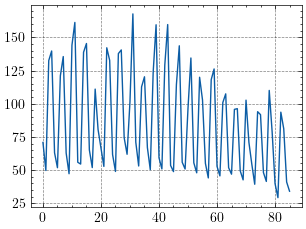

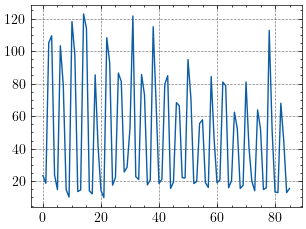

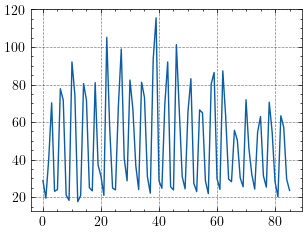

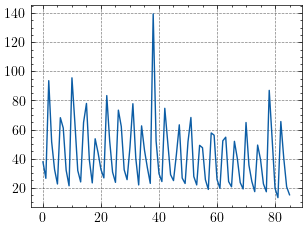

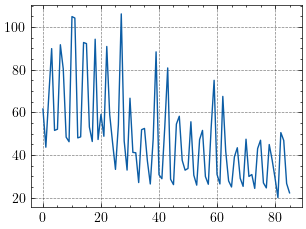

In [13]:
for comp in range(pca_components):
    plt.plot(comps_ts_masked[:,comp])
    plt.show()

In [15]:
d["results"]={'weights' : np.copy(Vr), 
'ts_unmasked':comps_ts,
'ts_masked':comps_ts_masked,
'explained_var':sorted_expvar,
'unrotated_weights':V,
'explained': sum(sorted_expvar)/total_var,
'pca_eigs':S,
'max_comps':pca_components,
'total_var' : total_var,
'month_mask':month_mask,
'start_end' : start_end,
'time' : [i for i in range(masked_data.shape[0])],
'lats' : geo_object.lats, 
'lons' : geo_object.lons }

Plotting loadings and time series to ./plots/no2_application/VARIMAX_5_NO2_v2.pdf 
(8, 28, 5) weights shape, check nr timetsteps
Saving plot...


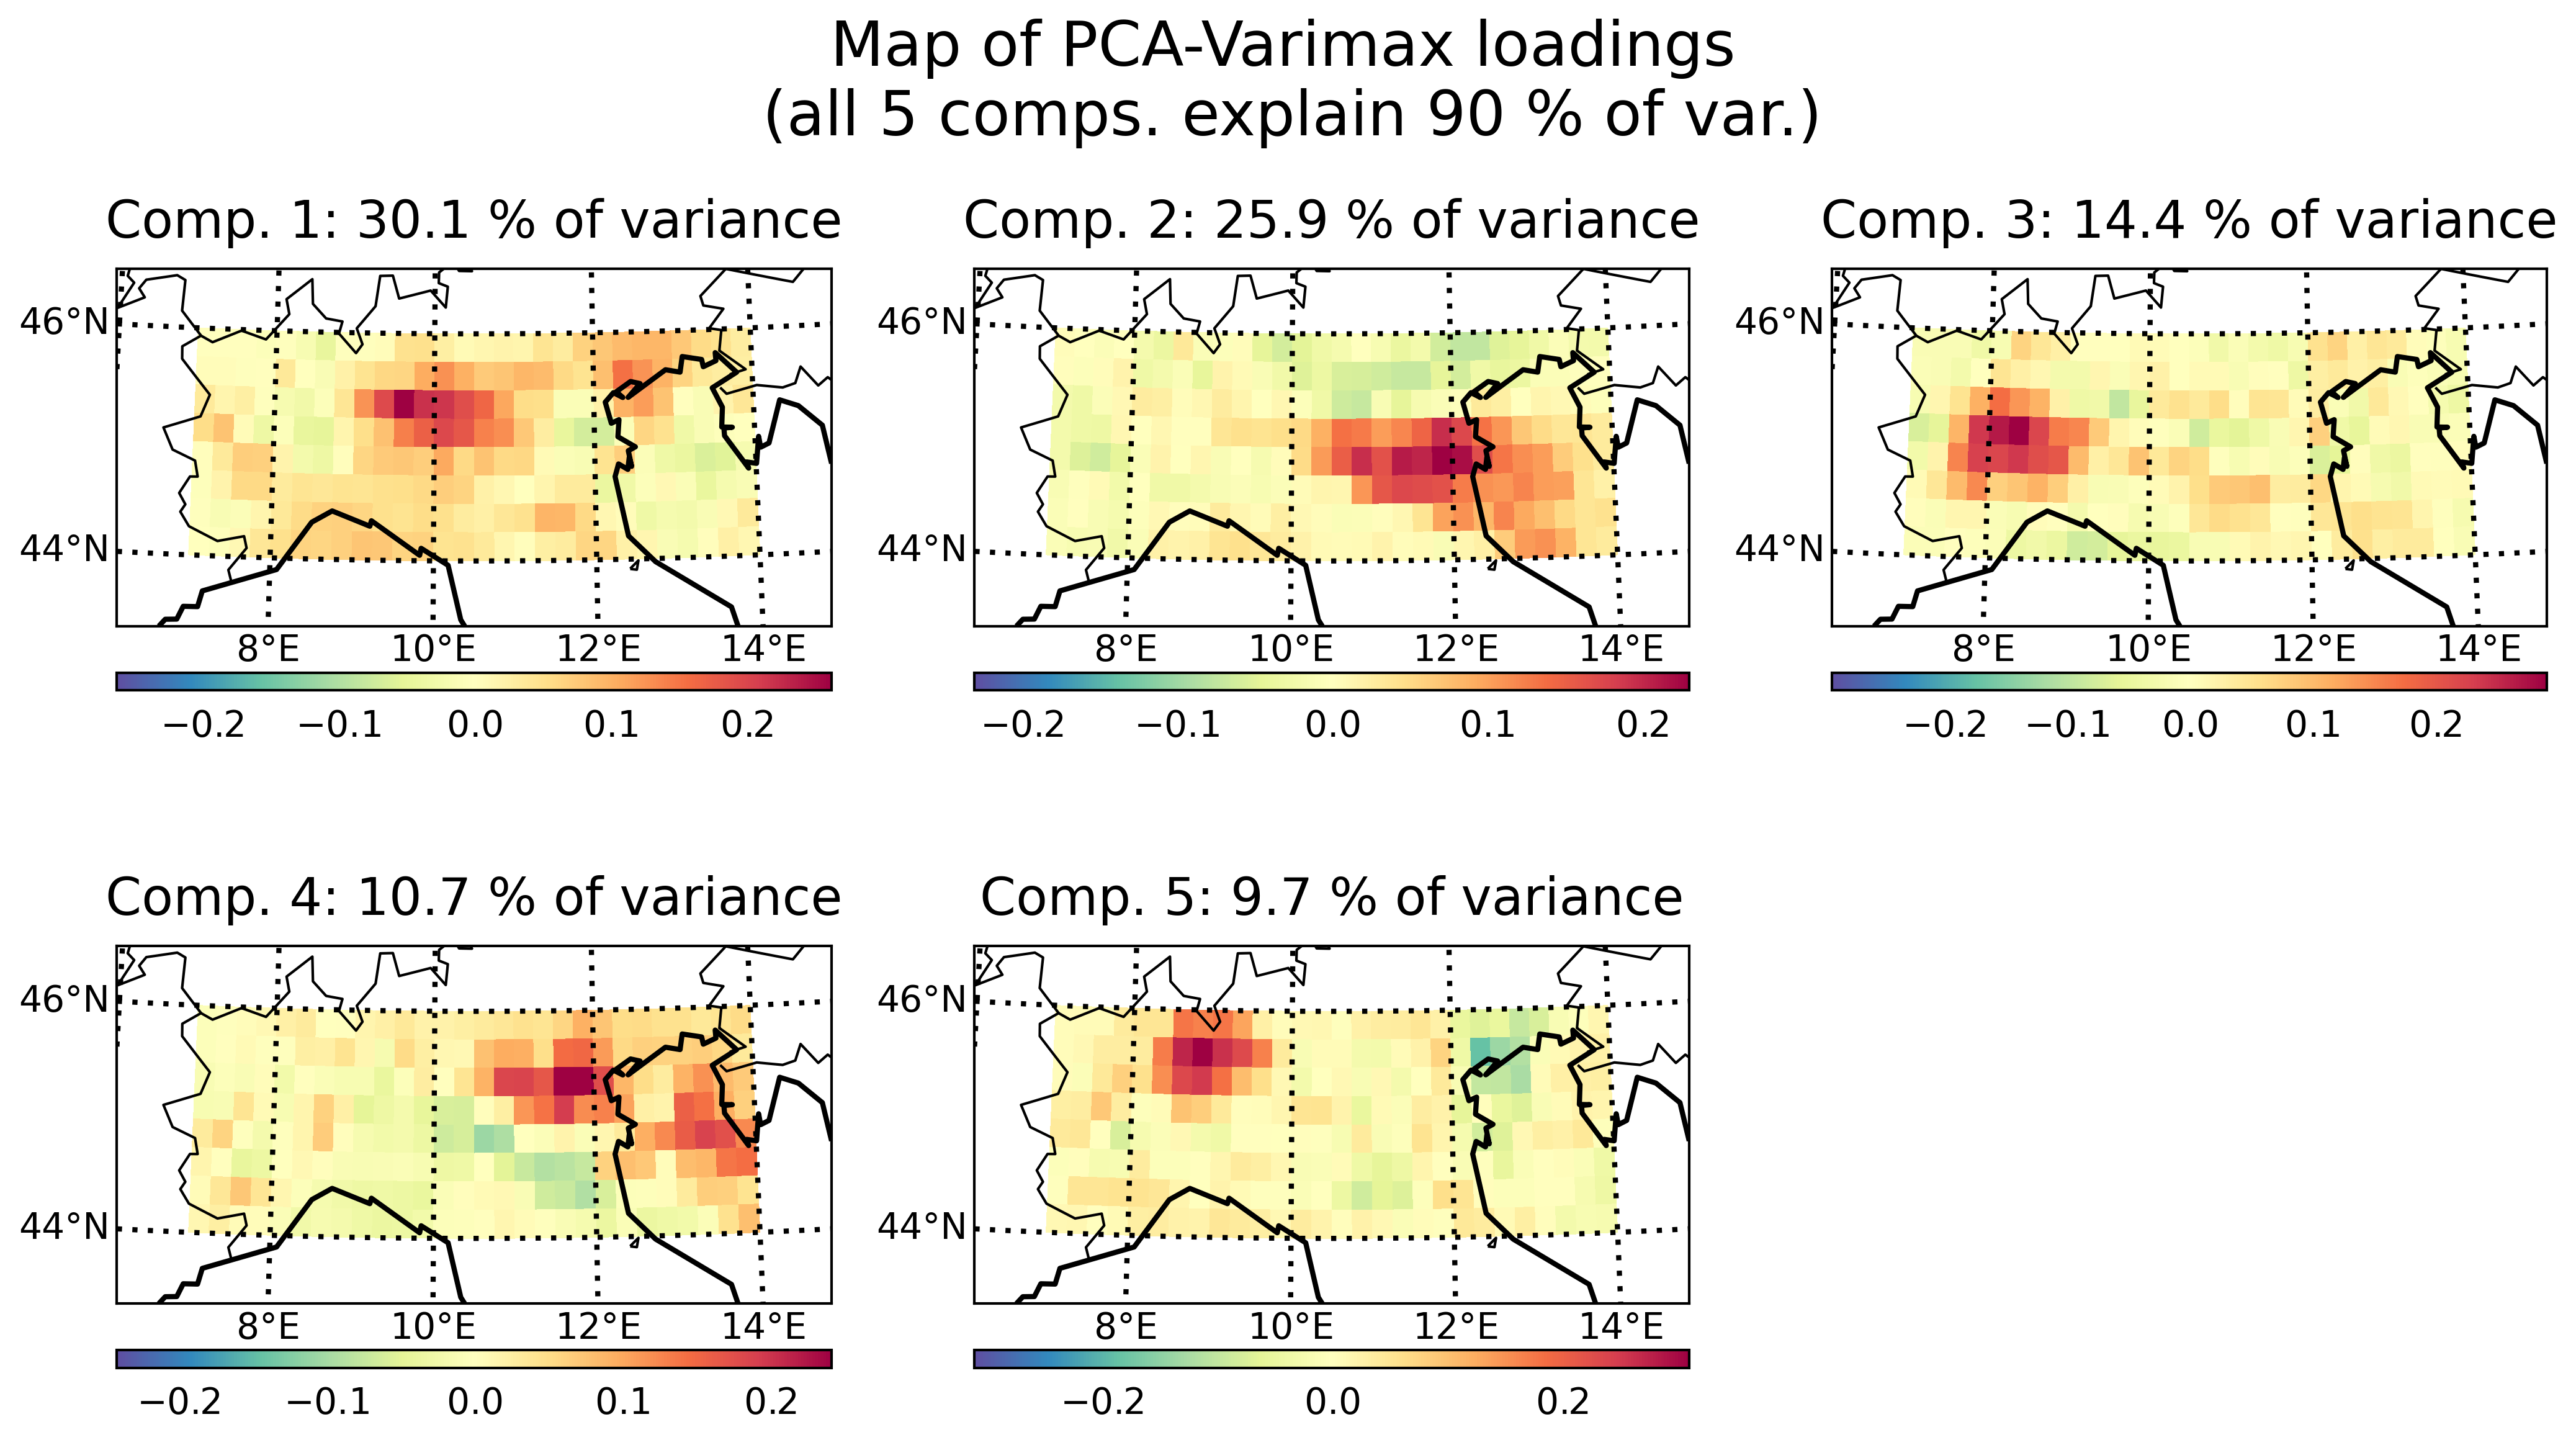

In [44]:
generate_pdf_loadings(d,pca_save_folder,save_filename,True)

In [22]:
#SAVE in CSV
ts_columns = ["PC"+str(i) for i in range(1,components+1)]
ts = pd.DataFrame(comps_ts[:,:components],columns=ts_columns, index=Q_df.index)
if save_output:
    ts.to_csv(pca_save_folder+pca_ts_save_file)
    with open(pca_res_save_path,"wb") as file_:
        cPickle.dump(d,file_)

## Merging NO2 data and Economic data

In [23]:
NO2_Q_df = ts
VA_df = pd.read_csv("./data/eco_data/Value added by industry quaterly-selected var.csv",
                   header=0,index_col=0)
CE_df = pd.read_csv("./data/eco_data/CE_selected_calendar_adjusted.csv",
                       header=0,index_col=0)

In [24]:
VA_df = VA_df.iloc[:,1:-17].transpose() #select corresponding years and transpose Value added dataframe
VA_df.index=NO2_Q_df.index
CE_df.index=NO2_Q_df.index
if log_transform:
    NO2_Q_df=pd.DataFrame(np.log(NO2_Q_df.values),columns=NO2_Q_df.columns, index=NO2_Q_df.index)
    VA_df= pd.DataFrame(np.log(VA_df.values),columns=VA_df.columns, index=VA_df.index)
    CE_df= pd.DataFrame(np.log(CE_df.values),columns=CE_df.columns, index=CE_df.index)

In [27]:
#Detrend each individual time series
   
if detrend_mode == "seasonal_decompose":
    for col in NO2_Q_df.columns:
        dec = seasonal_decompose(pd.DataFrame(NO2_Q_df[col],index=NO2_Q_df.index), model='additive', period=4)
        NO2_Q_df[col] = dec.observed-dec.trend-dec.seasonal
    for col in VA_df.columns:
        dec2 = seasonal_decompose(pd.DataFrame(VA_df[col],index=VA_df.index), model='add', period=4)
        VA_df[col] = dec2.observed-dec2.trend-dec2.seasonal
    for col in CE_df.columns:
        dec4 = seasonal_decompose(pd.DataFrame(CE_df[col],index=CE_df.index), model='add', period=4)
        CE_df[col] = dec4.observed-dec4.trend-dec4.seasonal
        
elif detrend_mode == "anomalize_mean_quarter":
    NO2_Q_df.dropna(inplace=True)
    for col in NO2_Q_df.columns:
        dec = seasonal_decompose(pd.DataFrame(NO2_Q_df[col],index=NO2_Q_df.index), model='additive', period=4)
        NO2_Q_df[col] = dec.observed-dec.trend
    if pca_anomalize!="means_variance" or pca_anomalize!="means":#to avoid anomalizing twice
        df = pd.DataFrame(NO2_Q_df.values, index=NO2_Q_df.index, columns =NO2_Q_df.columns)
        NO2_Q_df=df.groupby(df.index.quarter).transform(lambda x: x-x.mean())
    for col in VA_df.columns:
        dec2 = seasonal_decompose(pd.DataFrame(VA_df[col],index=VA_df.index), model='add', period=4)
        VA_df[col] = dec2.observed-dec2.trend
    df = pd.DataFrame(VA_df.values, index=VA_df.index, columns =VA_df.columns)
    VA_df=df.groupby(df.index.quarter).transform(lambda x: x-x.mean())
    for col in CE_df.columns:
        dec4 = seasonal_decompose(pd.DataFrame(CE_df[col],index=CE_df.index), model='add', period=4)
        CE_df[col] = dec4.observed-dec4.trend
    df = pd.DataFrame(CE_df.values, index=CE_df.index, columns =CE_df.columns)
    CE_df=df.groupby(df.index.quarter).transform(lambda x: x-x.mean())

elif detrend_mode == "diff":
    NO2_Q_df=NO2_Q_df.diff()
    VA_df = VA_df.diff()
    CE_df=CE_df.diff()
elif detrend_mode == "perc_change":
    NO2_Q_df=(NO2_Q_df - NO2_Q_df.shift()) / abs(NO2_Q_df.shift())*100
    VA_df=(VA_df - VA_df.shift()) / abs(VA_df.shift())*100
    CE_df=(CE_df - CE_df.shift()) / abs(CE_df.shift())*100
    
elif detrend_mode == "detrend_decompose":
    for col in NO2_Q_df.columns:
        dec = seasonal_decompose(pd.DataFrame(NO2_Q_df[col],index=NO2_Q_df.index), model='additive', period=4)
        NO2_Q_df[col] = dec.observed-dec.trend
    for col in VA_df.columns:
        dec2 = seasonal_decompose(pd.DataFrame(VA_df[col],index=VA_df.index), model='add', period=4)
        VA_df[col] = dec2.observed-dec2.trend
    for col in CE_df.columns:
        dec4 = seasonal_decompose(pd.DataFrame(CE_df[col],index=CE_df.index), model='add', period=4)
        CE_df[col] = dec4.observed-dec4.trend

In [28]:
NO2_Q_df.dropna(inplace=True)
VA_df.dropna(inplace=True)
CE_df.dropna(inplace=True)
stacked_df= pd.concat([NO2_Q_df,VA_df,CE_df],axis=1)
stacked_df_clean=stacked_df.dropna()

### Selection of relevant economic variables

In [29]:
if scaling:
    std_scaler = StandardScaler()

    stacked_df_scaled = std_scaler.fit_transform(stacked_df_clean.to_numpy())
    stacked_df = pd.DataFrame(stacked_df_scaled, columns=stacked_df_clean.columns,index=stacked_df_clean.index)

else:
    stacked_df=stacked_df_clean

In [30]:
Q1_ts = np.where(stacked_df.index.quarter == 1,1,-1/3)
Q2_ts = np.where(stacked_df.index.quarter == 2,1,-1/3)
#Q3_ts = np.where(stacked_df.index.quarter == 3,1,-1/3)
Q4_ts = np.where(stacked_df.index.quarter == 4,1,-1/3)

stacked_df["Q1"] = Q1_ts
stacked_df["Q2"] = Q2_ts
#stacked_df["Q3"] = Q3_ts
stacked_df["Q4"] = Q4_ts
N_quarter= 3

In [31]:
# Checking Stationarity with ADF Test on each column
for name, column in stacked_df.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "PC1" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.35
 No. Lags Chosen       = 10
 Critical value 1%     = -3.526
 Critical value 5%     = -2.903
 Critical value 10%    = -2.589
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "PC2" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.0646
 No. Lags Chosen       = 11
 Critical value 1%     = -3.527
 Critical value 5%     = -2.904
 Critical value 10%    = -2.589
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "PC3" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Te

In [ ]:
grangers_causation_matrix(stacked_df.iloc[:,:-N_quarter], variables = stacked_df.iloc[:,:-N_quarter].columns,test='ssr_chi2test', verbose=False,maxlag=1)

In [34]:
stacked_df_selected = stacked_df.drop(stacked_df.columns[[components,
                                                          components+1,components+2,
                                                          components+3,
                                                          components+4,
                                                          components+5,
                                                          components+6,#manufacturing
                                                          components+7,components+8,
                                                          components+9,#refinery of oil prod
                                                          components+10,components+11,components+12,components+13,components+15,
                                                          #components+14,
                                                          components+16,
                                                          components+17,
                                                          components+18,
                                                          components+19,components+20,
                                                          components+21,components+22,components+23,
                                                          #components+24,
                                                          components+25,
                                                         ]], axis=1)
stacked_df_selected.rename(columns={"Electricity, gas, and other activities":"VA-EG", "Housing and Energy Consumption":"FCE-HWE"},inplace=True)

In [36]:
dataframe = pp.DataFrame(stacked_df_selected.values, mask=None,var_names=stacked_df_selected.columns)
T, N = stacked_df_selected.values.shape
N_eco_var= N-components-N_quarter
parcorr = ParCorr(significance='analytic')
robparcorr = RobustParCorr()
pcmci = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=parcorr,
    verbosity=1)

In [38]:
def plot_df(df):
    fig = plt.figure(figsize=(7,5),dpi=600)
    subplot_num = {0: 421,1:422,2:423,3:424,4:425,5:427,6:428,7:429}
    for idx,column in enumerate(df.columns[:N_eco_var+components]):
        ax = fig.add_subplot(subplot_num[idx])
        color_= "black"
        title= column
        if idx>components-1: color_= "orange"
        if "PC" in title: title= title.replace("PC",r"$NO_2$ Comp.")
        df[column].plot(ax=ax,title=title, linewidth=1,color=color_)
        plt.tight_layout()
        plt.subplots_adjust(wspace=0.1, hspace=0.55)
    plt.suptitle("Time series of considered variables")
    fig.subplots_adjust(top=0.89)
    #plt.show()
    plt.savefig("./plots/no2_application/time_series.pdf",dpi=600)
    plt.show()

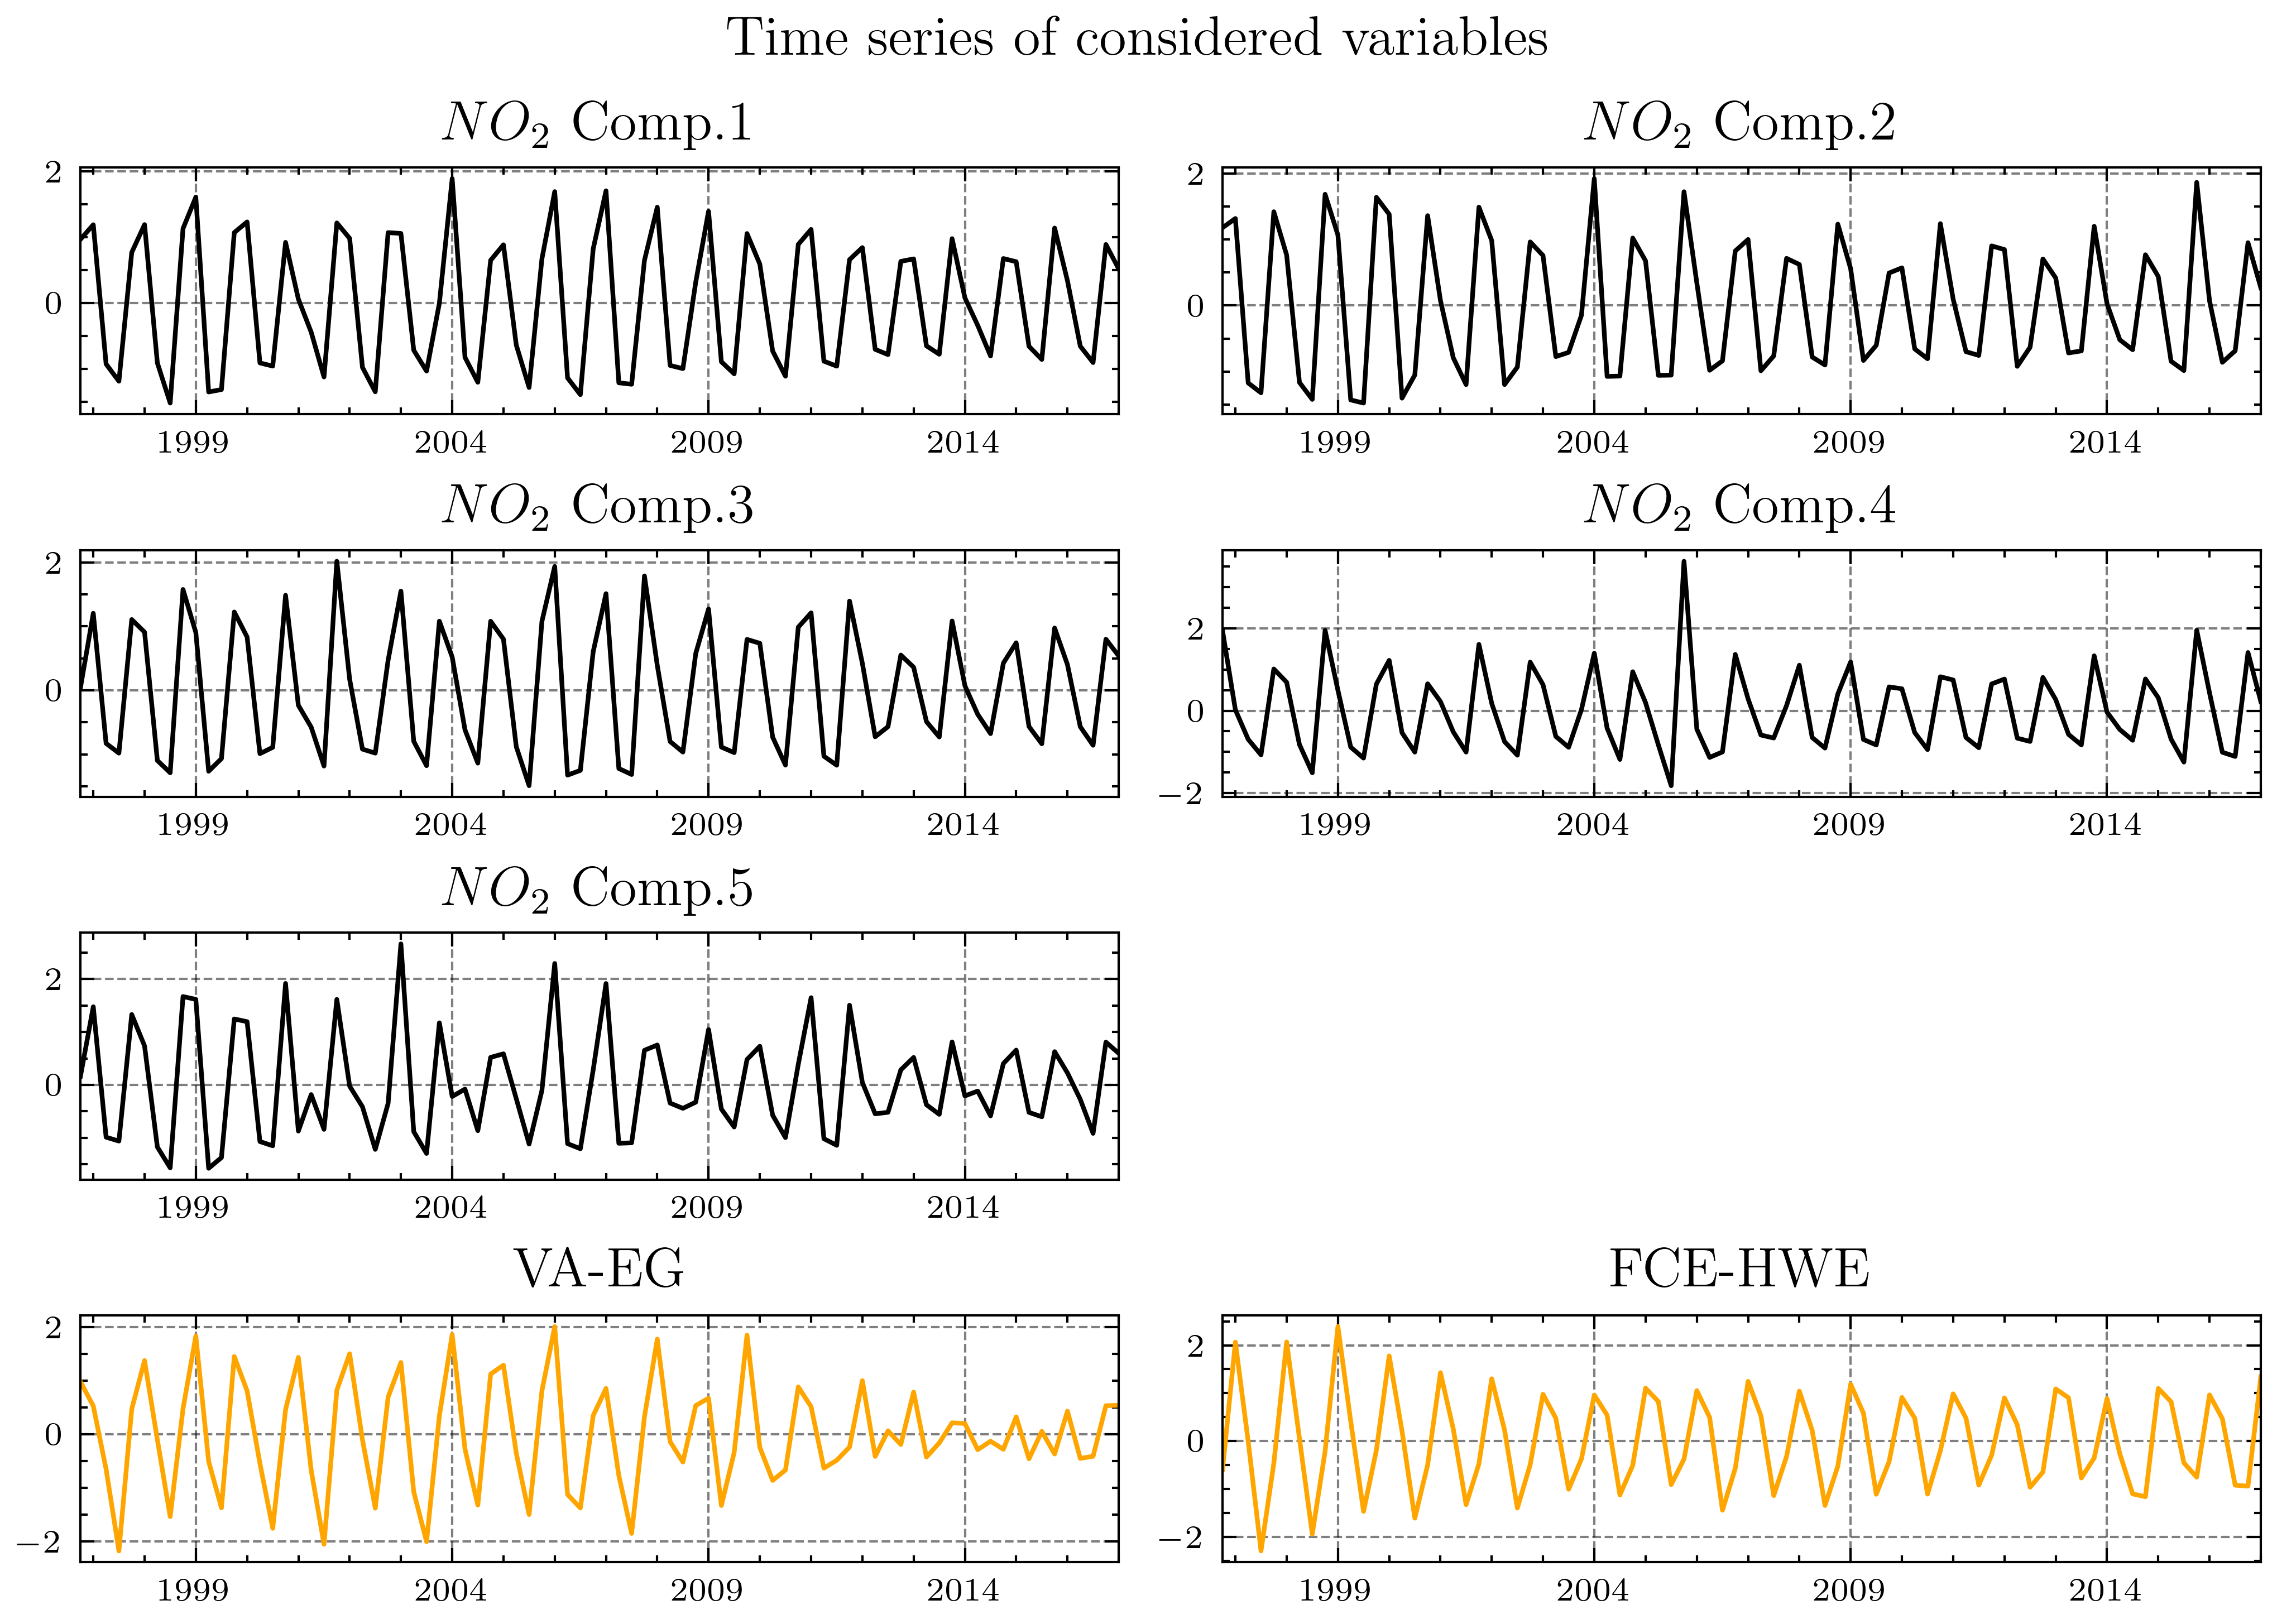

In [39]:
plot_df(stacked_df_selected)

## PCMCI+ parameters

In [40]:
# PCMCI param
pc_alpha= [0.1,0.2,0.3,0.4,0.5]

### Selected links 3: no link from NO2 PC to Eco, and no link from one NO2 PC to another, link for Eco to NO2 only at lag 0

In [41]:
min_lag,max_lag=0,1

In [42]:
dict_selected_links3={}
for key_dict in range(components):
    dict_selected_links3[key_dict]={}
    for var in range(components,components+N_eco_var):
        for tau in range(min_lag,1): 
            dict_selected_links3[key_dict][(var,-tau)]='-->'
    for var in range(components,N):
        for tau in range(min_lag,1): 
            dict_selected_links3[key_dict][(var,-tau)]='-->'
    for tau in range(1,max_lag+1):
        dict_selected_links3[key_dict][(key_dict,-tau)]='-->'
for key_dict in range(components,components+N_eco_var):
    dict_selected_links3[key_dict]={}
    for var in range(components+N_eco_var,N):
        for tau in range(0,1):
            dict_selected_links3[key_dict][(var,-tau)]='-->'
    for tau in range(1,max_lag+1):
        dict_selected_links3[key_dict][(key_dict,-tau)]='-->'
for key_dict in range(components+N_eco_var,N):
    dict_selected_links3[key_dict] = {}#preselected_links3

In [44]:
n_param=sum([len(l) for k,l in dict_selected_links3.items()])
#Construct of weights matrix from the NO2 PCA weights and the Economic variables
W_NO2 = d["results"]["weights"][:,:components]
W_eco=np.eye(N_eco_var)
#print(W_eco)
W= np.zeros((W_NO2.shape[0]+W_eco.shape[0],W_NO2.shape[1]+W_eco.shape[1]))
W[:W_NO2.shape[0],:W_NO2.shape[1]]=W_NO2
W[W_NO2.shape[0]:,W_NO2.shape[1]:]=W_eco
W=W.T
W_pinv = np.linalg.pinv(W)

### Robust Parcorr Selected links 3

In [45]:
dataframe = pp.DataFrame(stacked_df_selected.values, mask=None,var_names=stacked_df_selected.columns)
T, N = stacked_df_selected.values.shape
N_eco_var= N-components-N_quarter

In [46]:
parcorr = ParCorr(significance='analytic')
robparcorr = RobustParCorr()

pcmci_sel3_r = PCMCI(
    dataframe=dataframe,
    cond_ind_test=robparcorr,
    verbosity=1)
results_sel3_r = pcmci_sel3_r.run_pcmciplus(tau_min=min_lag,tau_max=max_lag,pc_alpha=pc_alpha,
                                  link_assumptions=dict_selected_links3,reset_lagged_links=True)


##
## Optimizing pc_alpha over pc_alpha_list = [0.1, 0.2, 0.3, 0.4, 0.5]
##

## pc_alpha = 0.1 (1/5):

##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
link_assumptions = {0: {(5, 0): '-->', (6, 0): '-->', (7, 0): '-->', (8, 0): '-->', (9, 0): '-->', (0, -1): '-->'}, 1: {(5, 0): '-->', (6, 0): '-->', (7, 0): '-->', (8, 0): '-->', (9, 0): '-->', (1, -1): '-->'}, 2: {(5, 0): '-->', (6, 0): '-->', (7, 0): '-->', (8, 0): '-->', (9, 0): '-->', (2, -1): '-->'}, 3: {(5, 0): '-->', (6, 0): '-->', (7, 0): '-->', (8, 0): '-->', (9, 0): '-->', (3, -1): '-->'}, 4: {(5, 0): '-->', (6, 0): '-->', (7, 0): '-->', (8, 0): '-->', (9, 0): '-->', (4, -1): '-->'}, 5: {(7, 0): '-->', (8, 0): '-->', (9, 0): '-->', (5, -1): '-->'}, 6: {(7, 0): '-->', (8, 0): '-->', (9, 0): '-->', (6, -1): '-->'}, 7: {}, 8: {}, 9: {}}
independence test = robust_par_corr
tau_min = 1
tau_max = 1
pc_alpha = [0.1]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable 

In [47]:
def get_VARcoeff_from_results(pcmci_to_use,results_to_use,dataframe_to_use,verbosity=0):
    p_matrix=results_to_use["p_matrix"]
    val_matrix=results_to_use["val_matrix"]
    tau_max=val_matrix.shape[2]-1
    graph=results_to_use["graph"]
    parents = pcmci_to_use.return_parents_dict(graph,val_matrix,include_lagzero_parents=True)
    med = LinearMediation(dataframe_to_use,
                 data_transform=None,
                 verbosity=0)
    med.fit_model(all_parents=parents,tau_max=tau_max,return_data= True)
    VAR_coeff_linmed = med.phi
    temp_df = pd.DataFrame(np.sum(VAR_coeff_linmed[:,:,:,],axis=0),
                           columns=dataframe_to_use.var_names,index=dataframe_to_use.var_names)
    if verbosity>0:
        display(temp_df)
    T,N=dataframe_to_use.values[0].shape
    #res = np.zeros((T-tau_max,N))
    res=dataframe_to_use.values[0][tau_max:,:]
    for var in med.fit_results.keys():
        sub_model = med.fit_results[var]
        saved_data = med.fit_results[var]["data"].T
        y=saved_data[:,1]
        x=saved_data[:,2:]
        if sub_model is not None:
            model=sub_model["model"]
            y_pred=model.predict(x)
            res[:,var]=y-y_pred
        else: res[:,var]= y
    cov_est= res.T@res/(T-tau_max)
#     if save_output:
#         np.save(pcmci_linear_med_save_path,phi_matrix)
    return VAR_coeff_linmed,cov_est,res

def compute_LTE(dataframe_to_use,VAR_coeff,W,W_pinv,N_eco_var,components):
    N,L = W.shape
    Id_N = np.eye(N)
    Id_L = np.eye(L)
    AK = np.sum(VAR_coeff[:,:,:],axis=0)
    Psi_inf= W_pinv@(np.linalg.inv(Id_N-AK)-Id_N)@W+Id_L #use the inverse of N-dim matrix for faster computations
    return Psi_inf

def plot_LTE(LTE_map,dataframe_to_use,N_eco_var,components,lats,lons,no2_units):
    print("Average LTE of a grid point increase on NO2 in Northern-Italy (in Std.Dev.): %f" %(LTE_map[:224,:224].mean()))
    for i in range(N_eco_var):
        var = dataframe_to_use.var_names[components+i]
        print("Average LTE of 1 StDev. increase of %s on NO2 in Northern-Italy (in Std.Dev.): %f" %(var[:15],np.mean(LTE_map[:224,224+i])))
    lon_0 = lons.mean()
    lat_0 = lats.mean()
    m = Basemap(width=700000,height=350000,
                resolution='l',projection='stere',\
                lat_0=lat_0,lon_0=lon_0)
    lon, lat = np.meshgrid(lons, lats)
    xi, yi = m(lon, lat)

    for i in range(N_eco_var):
        var = dataframe_to_use.var_names[components+i]
        impact_map = LTE_map[:224,224+i].reshape(8,28)
        
        # Plot Data
        plt.figure(figsize=(8, 6))
        cs = m.pcolor(xi,yi,np.squeeze(impact_map),cmap=mpl.cm.Spectral_r,vmin = np.amin(impact_map),
                        vmax = np.amax(impact_map))
        # Add Grid Lines
        m.drawparallels(np.arange(-80., 81., 2.), labels=[1,0,0,0], fontsize=13,dashes=[1,2],linewidth=1.5)
        m.drawmeridians(np.arange(-180., 181., 2.), labels=[0,0,0,1], fontsize=13,dashes=[1,2],linewidth=1.5)
        # Add Coastlines, States, and Country Boundaries
        m.drawcoastlines()
        m.drawstates()
        m.drawcountries()
        # Add Colorbar
        cbar = m.colorbar(cs, location='bottom', pad="10%")
        cbar.ax.tick_params(labelsize=13)
        NO2_string= r"$NO_2$"
        cbar.set_label(r"$NO_2$ pollution $(10^{15} molecules/cm^2$)",fontsize=15)
        if var=="VA-EG": caption_letter = "A"
        else: caption_letter = "B"
        plt.text(-0.15, 28, caption_letter, fontsize=22, fontweight='bold', ha='left', va='top', transform=cbar.ax.transAxes)
        # Add Title
        plt.title("Long-run effects of %s on %s pollution (in Std.Dev.)\n Average effect (sensitivity): %.2f" %(var,NO2_string,np.mean(LTE_map[:224,224+i])),fontsize=16)
        save_path = './plots/no2_application/%s_%s.pdf'%(var,"LTE_map")
        plt.savefig(save_path,dpi=600)
        print("Saved plot to %s"%save_path)
        plt.show()
        
def get_LTE_map_and_bound(LTE_map,LTE_cov_map,sigma):
    LTE_map=LTE_map[:224,224:]
    LTE_std_map_= np.sqrt(LTE_cov_map[:224,224:])
    LTE_upper_bound=LTE_map+sigma*LTE_std_map_
    LTE_lower_bound=LTE_map-sigma*LTE_std_map_
    return LTE_map,LTE_lower_bound,LTE_upper_bound

def plot_significant_LTE(LTE_map,LTE_lower_bound,LTE_upper_bound,var_names,lats,lons,no2_units, method_name="asymptotic"):

    lon_0 = lons.mean()
    lat_0 = lats.mean()
    m = Basemap(width=700000,height=350000,
                resolution='l',projection='stere',\
                lat_0=lat_0,lon_0=lon_0)
    lon, lat = np.meshgrid(lons, lats)
    xi, yi = m(lon, lat)
    dim2=LTE_map.shape[1]
    for i in range(dim2):
        var = var_names[i]
        #Check significance by checking if upper and lower bound have same sign
        #significance map, value of LTE or 0 if not significant
        nan_array = np.zeros(LTE_map[:,i].shape)
        nan_array[:]=np.nan
        general_impact_map = LTE_map[:,i].reshape(8,28)
        sig_map = np.where(np.sign(LTE_upper_bound[:,i]) == np.sign(LTE_lower_bound[:,i]),LTE_map[:,i],nan_array)
        impact_map = sig_map.reshape(8,28)
        # Plot Data
        plt.figure(figsize=(8, 6))
        cs = m.pcolor(xi,yi,np.squeeze(impact_map),cmap=mpl.cm.Spectral_r,vmin = np.amin(general_impact_map),
                        vmax = np.amax(general_impact_map))
        # Add Grid Lines
        m.drawparallels(np.arange(-80., 81., 2.), labels=[1,0,0,0], fontsize=13,dashes=[1,2],linewidth=1.5)
        m.drawmeridians(np.arange(-180., 181., 2.), labels=[0,0,0,1], fontsize=13,dashes=[1,2],linewidth=1.5)
        # Add Coastlines, States, and Country Boundaries
        m.drawcoastlines()
        m.drawstates()
        m.drawcountries()
        # Add Colorbar
        cbar = m.colorbar(cs, location='bottom', pad="10%")
        cbar.ax.tick_params(labelsize=13)
        cbar.set_label(r"$NO_2$ pollution $(10^{15} molecules/cm^2$)",fontsize=15)
        # Add Title
        alpha_string= r"$10\%$"
        NO2_string= r"$NO_2$"
        if "asymptotic" in method_name: 
            if var=="VA-EG": caption_letter = "C"
            else: caption_letter = "D"
        else:
            if var=="VA-EG": caption_letter = "E"
            else: caption_letter = "F"
        plt.text(-0.15, 28, caption_letter, fontsize=22, fontweight='bold', ha='left', va='top', transform=cbar.ax.transAxes)
        plt.title("Stat. sig. long-run effects of %s on %s pollution \n with a %s sig. level \n Average of significant effects: %.2f" %(var,NO2_string,alpha_string,np.nanmean(impact_map)),fontsize=16)
        save_path = './plots/no2_application/%s_%s_%s.pdf'%(var,"sigLTE_map",method_name)
        plt.savefig(save_path,dpi=600)
        print("Saved plot to %s"%save_path)
        plt.show()

def get_G(K,W,W_pinv,Psi_inf):
    return np.kron((K@W@Psi_inf).T,Psi_inf@W_pinv)

def get_asymptotic_LTE_cov_from_G(G,cov_VAR,N_sample):
    return (G@cov_VAR@G.T)/N_sample

def get_Z_from_dataframe(data,tau_min,tau_max):
    T_data,N_data= data.shape
    Z_t = np.zeros((N_data*(tau_max-tau_min+1),1))
    Z = np.zeros((N_data*(tau_max-tau_min+1),T_data-tau_max))
    for t in range(tau_max,T_data):
        tuple_Z_t=(data[t-tau,:] for tau in range(tau_min,tau_max+1))
        Z_t= np.hstack(tuple_Z_t).T
        Z[:,t-tau_max]=Z_t
    return Z

def get_Gamma_from_Z(Z):
    return Z@Z.T/Z.shape[1]

def get_LTE_cov_map_from_dataframe(dataframe,targets,Psi_inf,cov_res,W,W_pinv,min_lag,max_lag):
        data = dataframe.values[0][:,targets]
        Z = get_Z_from_dataframe(data,min_lag,max_lag)
        Gamma = get_Gamma_from_Z(Z)
        Gamma_pinv = np.linalg.pinv(Gamma)
        tau_dim = max_lag-min_lag+1
        N_sample = data.shape[0]-max_lag
        N=data.shape[1]
        K=np.zeros((tau_dim*N,N))
        for i in range(tau_dim):
            K[i*N:(i+1)*N,:]= np.eye(N,N)
        G=get_G(K,W,W_pinv,Psi_inf)
        cov_VAR = np.kron(Gamma_pinv,cov_res)
        print(cov_VAR.shape,G.shape)
        diag_LTE_cov = np.einsum('ij,ji->i', G@cov_VAR, G.T)/N_sample
        LTE_cov_map = diag_LTE_cov.reshape(224+N_eco_var,224+N_eco_var).T
        return LTE_cov_map
    

In [48]:
import scipy as sc
from scipy.stats import t
class LinearRegression(sklearn.linear_model.LinearRegression):
    #Modify LinearRegression to give p-value and t-statistics
    def __init__(self,*args,**kwargs):
        if not "fit_intercept" in kwargs:
            kwargs['fit_intercept'] = False

        super(LinearRegression,self).__init__(*args,**kwargs)
    # Adding in t-statistics for the coefficients.
    def fit(self,X,y):
        # This takes in numpy arrays (not matrices). Also assumes you are leaving out the column
        # of constants.
        self = super(LinearRegression, self).fit(X,y)
        n, k = X.shape
        yHat = np.matrix(self.predict(X)).T

        # Change X and Y into numpy matricies. x also has a column of ones added to it.
        x = np.hstack((np.ones((n,1)),np.matrix(X)))
        y = np.matrix(y).T

        # Degrees of freedom.
        df = float(n-k-1)

        # Sample variance.     
        sse = np.sum(np.square(yHat - y),axis=0)
        self.sampleVariance = sse/df

        # Sample variance for x.
        self.sampleVarianceX = x.T*x

        # Covariance Matrix = [(s^2)(X'X)^-1]^0.5. (sqrtm = matrix square root.  ugly)
        self.covarianceMatrix = sc.linalg.sqrtm(self.sampleVariance[0,0]*self.sampleVarianceX.I)

        # Standard erros for the difference coefficients: the diagonal elements of the covariance matrix.
        self.se = self.covarianceMatrix.diagonal()[1:]

        # T statistic for each beta.
        self.betasTStat = np.zeros(len(self.se))
        for i in range(len(self.se)):
            self.betasTStat[i] = self.coef_[i]/self.se[i]

        # P-value for each beta. This is a two sided t-test, since the betas can be 
        # positive or negative.
        self.betasPValue = 1 - t.cdf(abs(self.betasTStat),df)

def get_MODELcoeff_from_results(pcmci_to_use,results_to_use,dataframe_to_use,targets,verbosity=0):
    LinReg = LinearRegression()
    p_matrix=results_to_use["p_matrix"]
    val_matrix=results_to_use["val_matrix"]
    tau_max=val_matrix.shape[2]-1
    graph=results_to_use["graph"]
    T_,N_ = dataframe_to_use.values[0].shape
    N_target = len(targets)
    parents = pcmci_to_use.return_parents_dict(graph,val_matrix,include_lagzero_parents=True)
    model= Prediction(dataframe_to_use,
                      train_indices=list(range(T_)),
                      test_indices=[],
                      prediction_model= LinReg)
    model.fit(target_predictors= parents,
             selected_targets=targets,
             tau_max = tau_max,
             return_data=True)
    
    #Construct the matrix of coefficient from fitted LinearRegressions
    coeff_mat = np.zeros((tau_max+1,N_target,N_target))
    pval_mat = np.zeros((tau_max+1,N_target,N_target))
    tstat_mat = np.zeros((tau_max+1,N_target,N_target))
    dummy_mat = np.zeros((N_target,N_-N_target))
    dummy_tstat_mat = np.zeros((N_target,N_-N_target))
    dummy_pval_mat = np.zeros((N_target,N_-N_target))
    dummy_idx = [i for i in range(N_) if i not in targets]
    for target_id,submodel in model.fitted_model.items():
        if submodel is not None:
            submodel_coefs = submodel["model"].coef_
            submodel_pval= submodel["model"].betasPValue
            submodel_tstat= submodel["model"].betasTStat
        else: submodel_coefs= []
        for i,elem in enumerate(parents[target_id]):
            parent,lag = elem[0],elem[1]
            if parent in targets:
                coeff_mat[-lag,target_id,targets.index(parent)] = submodel_coefs[i]
                pval_mat[-lag,target_id,targets.index(parent)] = submodel_pval[i]
                tstat_mat[-lag,target_id,targets.index(parent)] = submodel_tstat[i]
                
            else:
                dummy_mat[target_id,dummy_idx.index(parent)]= submodel_coefs[i]
                dummy_pval_mat[target_id,dummy_idx.index(parent)] = submodel_pval[i]
                dummy_tstat_mat[target_id,dummy_idx.index(parent)] = submodel_tstat[i]
    if verbosity>0:
        print("Linear coefficient/P-values/T-stat matrices by lag")
        for lag in range(tau_max+1):
            coef_df = pd.DataFrame(coeff_mat[lag,...],
            columns=dataframe_to_use.var_names[targets],index=dataframe_to_use.var_names[targets])
            pval_df = pd.DataFrame(pval_mat[lag,...],
            columns=dataframe_to_use.var_names[targets],index=dataframe_to_use.var_names[targets])
            tstat_df = pd.DataFrame(tstat_mat[lag,...],
            columns=dataframe_to_use.var_names[targets],index=dataframe_to_use.var_names[targets])
            print("Linear coefficients for lag %d"%lag)
            display(coef_df)
            print("P-Values for lag %d"%lag)
            display(pval_df)
            print("T-stat for lag %d"%lag)
            display(tstat_df)
            
        dummy_df = pd.DataFrame(dummy_mat,
                            columns=dataframe_to_use.var_names[dummy_idx],index=dataframe_to_use.var_names[targets])
        dummy_pval_df = pd.DataFrame(dummy_pval_mat,
                            columns=dataframe_to_use.var_names[dummy_idx],index=dataframe_to_use.var_names[targets])
        dummy_tstat_df = pd.DataFrame(dummy_tstat_mat,
                            columns=dataframe_to_use.var_names[dummy_idx],index=dataframe_to_use.var_names[targets])
        print("Dummy coefficients")
        display(dummy_df)
        print("Dummy P-Values")
        display(dummy_pval_df)
        print("Dummy T-stat")
        display(dummy_tstat_df)
    #Calculate residuals using predict function
    res_ = np.zeros((T-tau_max,N_target))
    for i in range(len(targets)):
        y_true = dataframe_to_use.values[0][tau_max:,targets[i]]
        if model.fitted_model[i] is not None:
            target_pred = model.predict(target=targets[i],
                      new_data= dataframe_to_use,
                      cut_off="tau_max")
            y_pred = target_pred[:,]
        else: y_pred= y_true*0
        #print(model.fitted_model)
        R2= 1-((y_true - y_pred)** 2).sum()/((y_true - y_true.mean()) ** 2).sum()
        if verbosity>0:
            print("R2 for variable %s: %f"%(dataframe_to_use.var_names[i][:17],R2))
        res_[:,i] = y_true-y_pred
    cov_est=np.cov(res_.T)
    return coeff_mat,dummy_mat,cov_est,res_

Linear coefficient/P-values/T-stat matrices by lag
Linear coefficients for lag 0


,PC1,PC2,PC3,PC4,PC5,VA-EG,FCE-HWE
PC1,0.0,0.0,0.0,0.0,0.0,0.78,-0.14
PC2,0.0,0.0,0.0,0.0,0.0,0.00,0.00
PC3,0.0,0.0,0.0,0.0,0.0,0.64,0.00
PC4,0.0,0.0,0.0,0.0,0.0,0.00,0.49
PC5,0.0,0.0,0.0,0.0,0.0,0.00,1.03
VA-EG,0.0,0.0,0.0,0.0,0.0,0.00,0.00
FCE-HWE,0.0,0.0,0.0,0.0,0.0,0.00,0.00


P-Values for lag 0


,PC1,PC2,PC3,PC4,PC5,VA-EG,FCE-HWE
PC1,0.0,0.0,0.0,0.0,0.0,0.00e+00,5.02e-02
PC2,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.00e+00
PC3,0.0,0.0,0.0,0.0,0.0,1.11e-16,0.00e+00
PC4,0.0,0.0,0.0,0.0,0.0,0.00e+00,6.76e-11
PC5,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.00e+00
VA-EG,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.00e+00
FCE-HWE,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.00e+00


T-stat for lag 0


,PC1,PC2,PC3,PC4,PC5,VA-EG,FCE-HWE
PC1,0.0,0.0,0.0,0.0,0.0,10.81,-1.66
PC2,0.0,0.0,0.0,0.0,0.0,0.00,0.00
PC3,0.0,0.0,0.0,0.0,0.0,10.47,0.00
PC4,0.0,0.0,0.0,0.0,0.0,0.00,7.40
PC5,0.0,0.0,0.0,0.0,0.0,0.00,11.35
VA-EG,0.0,0.0,0.0,0.0,0.0,0.00,0.00
FCE-HWE,0.0,0.0,0.0,0.0,0.0,0.00,0.00


Linear coefficients for lag 1


,PC1,PC2,PC3,PC4,PC5,VA-EG,FCE-HWE
PC1,0.0,0.0,0.0,0.0,0.00,0.0,0.0
PC2,0.0,0.0,0.0,0.0,0.00,0.0,0.0
PC3,0.0,0.0,0.0,0.0,0.00,0.0,0.0
PC4,0.0,0.0,0.0,0.0,0.00,0.0,0.0
PC5,0.0,0.0,0.0,0.0,-0.86,0.0,0.0
VA-EG,0.0,0.0,0.0,0.0,0.00,0.0,0.0
FCE-HWE,0.0,0.0,0.0,0.0,0.00,0.0,0.0


P-Values for lag 1


,PC1,PC2,PC3,PC4,PC5,VA-EG,FCE-HWE
PC1,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0
PC2,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0
PC3,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0
PC4,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0
PC5,0.0,0.0,0.0,0.0,7.88e-15,0.0,0.0
VA-EG,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0
FCE-HWE,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0


T-stat for lag 1


,PC1,PC2,PC3,PC4,PC5,VA-EG,FCE-HWE
PC1,0.0,0.0,0.0,0.0,0.00,0.0,0.0
PC2,0.0,0.0,0.0,0.0,0.00,0.0,0.0
PC3,0.0,0.0,0.0,0.0,0.00,0.0,0.0
PC4,0.0,0.0,0.0,0.0,0.00,0.0,0.0
PC5,0.0,0.0,0.0,0.0,-9.43,0.0,0.0
VA-EG,0.0,0.0,0.0,0.0,0.00,0.0,0.0
FCE-HWE,0.0,0.0,0.0,0.0,0.00,0.0,0.0


Dummy coefficients


,Q1,Q2,Q4
PC1,0.41,0.00,0.00
PC2,0.00,-0.92,0.00
PC3,0.00,0.00,0.72
PC4,0.00,0.00,1.36
PC5,0.00,0.00,0.00
VA-EG,1.02,0.00,0.00
FCE-HWE,1.60,0.94,0.00


Dummy P-Values


,Q1,Q2,Q4
PC1,4.28e-03,0.00e+00,0.00e+00
PC2,0.00e+00,1.52e-07,0.00e+00
PC3,0.00e+00,0.00e+00,1.72e-09
PC4,0.00e+00,0.00e+00,0.00e+00
PC5,0.00e+00,0.00e+00,0.00e+00
VA-EG,2.46e-09,0.00e+00,0.00e+00
FCE-HWE,0.00e+00,0.00e+00,0.00e+00


Dummy T-stat


,Q1,Q2,Q4
PC1,2.70,0.00,0.00
PC2,0.00,-5.60,0.00
PC3,0.00,0.00,6.66
PC4,0.00,0.00,11.58
PC5,0.00,0.00,0.00
VA-EG,6.57,0.00,0.00
FCE-HWE,18.29,10.62,0.00


R2 for variable PC1: 0.732040
R2 for variable PC2: 0.283792
R2 for variable PC3: 0.728410
R2 for variable PC4: 0.657718
R2 for variable PC5: 0.599621
R2 for variable VA-EG: 0.353240
R2 for variable FCE-HWE: 0.816113
Average LTE of a grid point increase on NO2 in Northern-Italy (in Std.Dev.): 0.004351
Average LTE of 1 StDev. increase of VA-EG on NO2 in Northern-Italy (in Std.Dev.): 0.043448
Average LTE of 1 StDev. increase of FCE-HWE on NO2 in Northern-Italy (in Std.Dev.): 0.015624
Saved plot to ./plots/no2_application/VA-EG_LTE_map.pdf


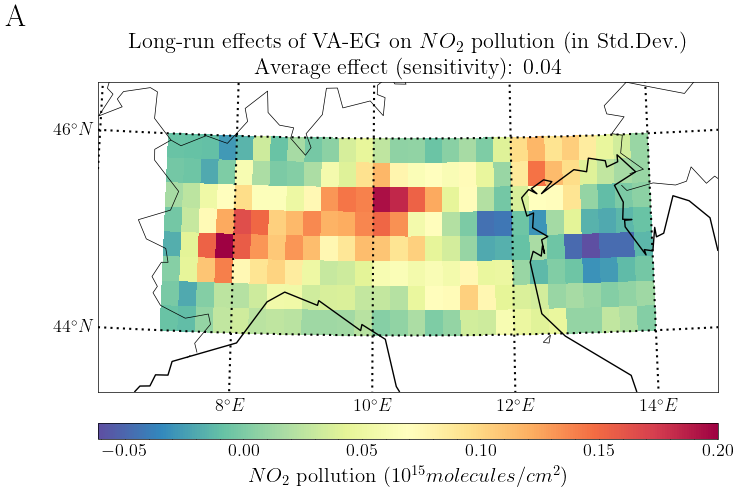

Saved plot to ./plots/no2_application/FCE-HWE_LTE_map.pdf


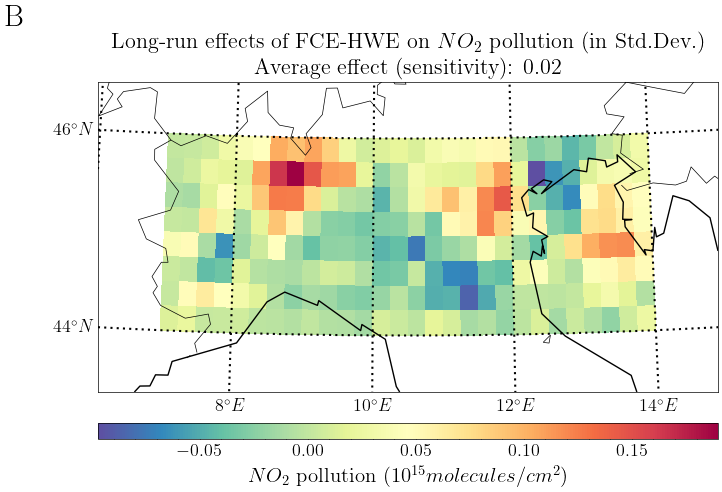

In [49]:
results_to_use= results_sel3_r#results_adj_sel
pcmci_to_use= pcmci_sel3_r
dataframe_to_use= dataframe
targets= list(range(components+N_eco_var))
coef_,dummy_coef_,cov_,res_= get_MODELcoeff_from_results(pcmci_to_use,results_to_use,dataframe_to_use,targets,1)
ds = Dataset(no2_data_path+pca_input_file, mode='r')
lons = ds.variables['lon'][:]
lats = ds.variables['lat'][:]
no2_units = ds.variables['TroposNO2'].units
ds.close()
Psi_inf = compute_LTE(dataframe_to_use,coef_,W,W_pinv,N_eco_var,components)
plot_LTE(Psi_inf,dataframe_to_use,N_eco_var,components,lats,lons,no2_units)

In [50]:
def predict_from_VARcoefs(VAR,array,min_lag=0):
    tau_max,N_var,_=VAR.shape
    tau_max += -1+min_lag
    T=array.shape[0]
    y_pred= np.zeros(array.shape)
    
    for i in range(tau_max,T):
        for t in reversed(range(min_lag,tau_max+1)):
            y_pred[i,...]+=array[i-t,...].dot(VAR[t,...].T)
            
    return y_pred[tau_max:,...]
def compute_res_and_cov(array,VAR,min_lag=0):
    tau_max,N_var,_=VAR.shape
    tau_max-=1
    y_pred=predict_from_VARcoefs(VAR,array,min_lag=0)
    res=array[tau_max:,...]-y_pred
    cov_res= res.T@res/(T-tau_max)
    return res,cov_res

## Asymptotic distribution based CI

(98, 98) (51076, 98)
[0.061362706599614604, 0.058039219798788365]
Saved plot to ./plots/no2_application/VA-EG_sigLTE_map_asymptotic.pdf


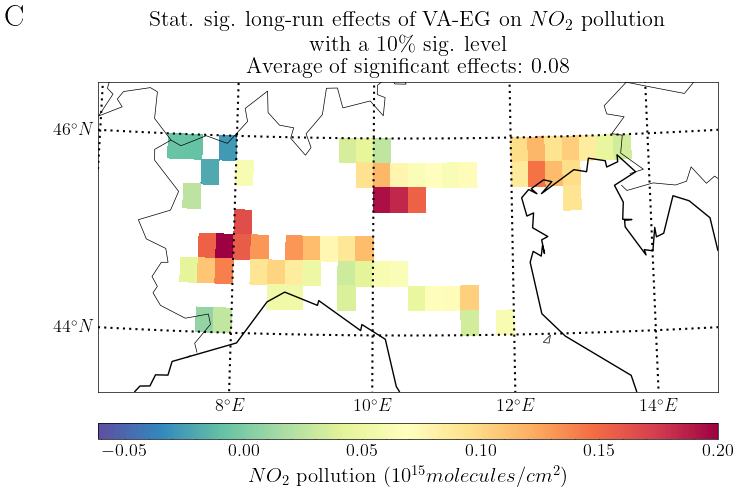

Saved plot to ./plots/no2_application/FCE-HWE_sigLTE_map_asymptotic.pdf


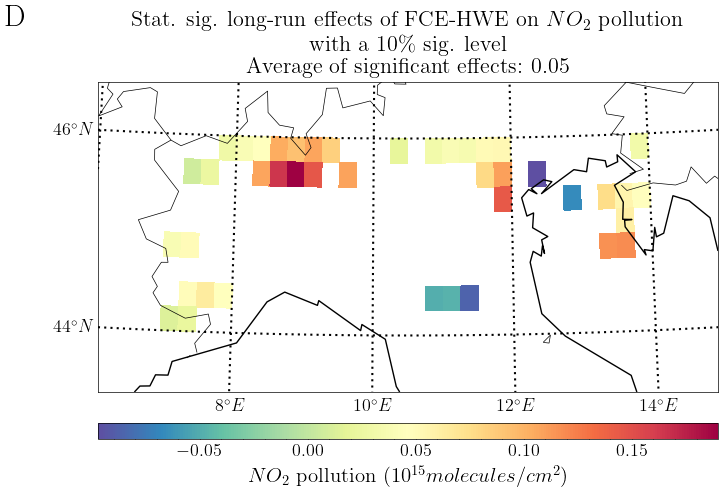

In [51]:
LTE_cov_map = get_LTE_cov_map_from_dataframe(dataframe,targets,Psi_inf,cov_,W,W_pinv,min_lag,max_lag)
ci_list=[]
for i in range(0,N_eco_var):
    ci_list.append(np.sqrt(LTE_cov_map[:224,224+i]))
print([np.mean(l) for l in ci_list])
sigma= 1.28
LTE_map,LTE_lower_bound,LTE_upper_bound=get_LTE_map_and_bound(Psi_inf,LTE_cov_map,sigma)
plot_significant_LTE(LTE_map,LTE_lower_bound,LTE_upper_bound,dataframe.var_names[components:-N_quarter],lats,lons,no2_units)

## Bootstrap-based CI

In [66]:
def generate_ts_from_coefs_and_residuals(VAR,dummy_coef,res,array,targets,min_lag=0):
    
        tau_max,N_target,_=VAR.shape
        N_var= array.shape[1]
        tau_max += -1+min_lag
        T=array.shape[0]
        T_transient = res.shape[0] #total sample size with transient fraction
        y_gen= np.zeros((T_transient,N_target))
        y_gen+= res #add noise
        y_gen[:tau_max+1,...]= array[:tau_max+1,targets] #initial values
        #initial_idx = np.random.randint(0,T-tau_max-1)
        #y_gen[:tau_max+1,...]= array[initial_idx:initial_idx+tau_max+1,targets] #initial values
        dummy_idx= [i for i in range(N_var) if i not in targets]
        
        # create extended dummy array
        dummy_gen = np.zeros((T_transient,len(dummy_idx)))
        dummy_array= array[:,dummy_idx]
        idx_end_copy = np.argwhere(dummy_array[:,0]==1.)[-1][0]
        idx_start_copy = np.argwhere(dummy_array[:,0]==1.)[0][0]
        dummy_gen[:idx_end_copy,:]= dummy_array[:idx_end_copy,:]
        current_idx=idx_end_copy
        while current_idx < T_transient:
            end = min(current_idx+idx_end_copy-idx_start_copy,T_transient)
            dummy_gen[current_idx:end,:]= dummy_array[idx_start_copy:end-current_idx+idx_start_copy,:]
            current_idx += idx_end_copy-idx_start_copy
        
        #Generate time series
        for i in range(tau_max+1,T_transient):
            for t in reversed(range(min_lag,tau_max+1)):
                y_gen[i,...]+= y_gen[i-t,...].dot(VAR[t,...].T)
            y_gen[i,...]+= dummy_gen[i,...].dot(dummy_coef.T)
        new_array= np.zeros((T,N_var))
        new_array[:,targets]=y_gen[T_transient-T:,...]
        new_array[:,dummy_idx]=dummy_gen[T_transient-T:,...]
        return new_array

def get_normal_bootstrap_LTE(pcmci_to_use,results_to_use,dataframe,VAR_coeff,dummy_coef,res_,targets,
                             n_bootstrap,burnout,min_lag,max_lag):
    "Perform normal bootstrapping on the residuals and estimate LTE Confidence interval"
    data=dataframe.values[0]
    all_LTE_map=[]
    res_df=pd.DataFrame(res_)
    T_ = res_df.shape[0]
    for i_bs in range(n_bootstrap):
        new_res_df = res_df.sample(n=T_+burnout,replace=True,axis=0)
        new_res = new_res_df.values
        new_res-= new_res.mean(axis=0) #center the residuals
        new_data= generate_ts_from_coefs_and_residuals(VAR_coeff,dummy_coef,new_res,data,targets,min_lag=0) #generate ts recursively
        new_dataframe = pp.DataFrame(new_data)
        
        parcorr = ParCorr(significance='analytic')
        robparcorr = RobustParCorr()
        new_pcmci = PCMCI(
            dataframe=new_dataframe,
            cond_ind_test=robparcorr,
            verbosity=0)
        new_results = new_pcmci.run_pcmciplus(tau_min=0,tau_max=max_lag,pc_alpha=pc_alpha,
                                  link_assumptions=dict_selected_links3,reset_lagged_links=True)
        new_VAR,dummy_mat,new_cov_,new_res_ = get_MODELcoeff_from_results(new_pcmci,new_results,
                                                                  new_dataframe,targets,verbosity=0)

        new_Psi_inf = compute_LTE(new_dataframe,new_VAR,W,W_pinv,N_eco_var,components)
        if np.mean(np.abs(new_Psi_inf))>10e2: #If singular Psi_inf, go to next iteration
            print(np.mean(np.abs(new_Psi_inf)))
            continue
        all_LTE_map.append(new_Psi_inf[:224,224:].reshape(224*N_eco_var))
    df_res = pd.DataFrame(np.array(all_LTE_map),index=[i for i in range(len(all_LTE_map))],columns=[str(j) for j in range(224*N_eco_var)])
    return df_res

def get_CI_from_bootstrap(bootstrap_df,sig_level):
    df_out = pd.DataFrame(np.zeros((4,224*N_eco_var)),index=["mean","median","lower_CI","upper_CI"],columns=bootstrap_df.columns)
    for col in bootstrap_df.columns:
        lower_bound = bootstrap_df[col].quantile(sig_level/2)
        upper_bound = bootstrap_df[col].quantile(1-sig_level/2)
        mean=bootstrap_df[col].mean()
        median=bootstrap_df[col].median()
        df_out[col]=[mean,median,lower_bound,upper_bound]
    mean_s=df_out.loc["mean"].values.reshape(224,N_eco_var)
    median_s=df_out.loc["median"].values.reshape(224,N_eco_var)
    lower_ci_s=df_out.loc["lower_CI"].values.reshape(224,N_eco_var)
    upper_ci_s=df_out.loc["upper_CI"].values.reshape(224,N_eco_var)
    return mean_s,median_s,lower_ci_s,upper_ci_s
            
def get_hall_bootstrap_LTE(pcmci_to_use,results_to_use,dataframe,VAR_coeff,dummy_coef,res_,targets,
                             n_bootstrap,burnout,min_lag,max_lag):
    "Perform Hall correction bootstrapping on the residuals and estimate LTE Confidence interval"
    estimated_Psi_inf = compute_LTE(dataframe,VAR_coeff,W,W_pinv,N_eco_var,components)
    data=dataframe.values[0]
    all_LTE_map=[]
    res_df=pd.DataFrame(res_)
    T_ = res_df.shape[0]
    for i_bs in range(n_bootstrap):
        new_res_df = res_df.sample(n=T_+burnout,replace=True,axis=0)
        new_res = new_res_df.values
        new_res-= new_res.mean(axis=0) #center the residuals
        new_data= generate_ts_from_coefs_and_residuals(VAR_coeff,dummy_coef,new_res,data,targets,min_lag=0) #generate ts recursively
        new_dataframe = pp.DataFrame(new_data)
        parcorr = ParCorr(significance='analytic')
        robparcorr = RobustParCorr()
        new_pcmci = PCMCI(
            dataframe=new_dataframe,
            cond_ind_test=robparcorr,
            verbosity=0)
        new_results = new_pcmci.run_pcmciplus(tau_min=0,tau_max=max_lag,pc_alpha=pc_alpha,
                                  link_assumptions=dict_selected_links3,reset_lagged_links=True)
        new_VAR,dummy_mat,new_cov_,new_res_ = get_MODELcoeff_from_results(new_pcmci,new_results,
                                                                  new_dataframe,targets,verbosity=0)
        new_Psi_inf = compute_LTE(new_dataframe,new_VAR,W,W_pinv,N_eco_var,components)
        if np.mean(np.abs(new_Psi_inf))>10e2: #If singular Psi_inf, go to next iteration
            print(np.mean(np.abs(new_Psi_inf)))
            continue
        delta_Psi_inf = (new_Psi_inf-estimated_Psi_inf)
        all_LTE_map.append(delta_Psi_inf[:224,224:].reshape(224*N_eco_var))
    df_res = pd.DataFrame(np.array(all_LTE_map),index=[i for i in range(len(all_LTE_map))],columns=[str(j) for j in range(224*N_eco_var)])
    return df_res

def get_hall_CI_from_bootstrap(bootstrap_df,estimated_Psi_inf,sig_level):
    df_out = pd.DataFrame(np.zeros((4,224*N_eco_var)),index=["mean","median","lower_CI","upper_CI"],columns=bootstrap_df.columns)
    for col in bootstrap_df.columns:
        lower_bound = -bootstrap_df[col].quantile(1-sig_level/2)+estimated_Psi_inf[int(col)]
        upper_bound = -bootstrap_df[col].quantile(sig_level/2)+estimated_Psi_inf[int(col)]
        mean=-bootstrap_df[col].mean()+estimated_Psi_inf[int(col)]
        median=-bootstrap_df[col].median()+estimated_Psi_inf[int(col)]
        df_out[col]=[mean,median,lower_bound,upper_bound]
    mean_s=df_out.loc["mean"].values.reshape(224,N_eco_var)
    median_s=df_out.loc["median"].values.reshape(224,N_eco_var)
    lower_ci_s=df_out.loc["lower_CI"].values.reshape(224,N_eco_var)
    upper_ci_s=df_out.loc["upper_CI"].values.reshape(224,N_eco_var)
    return mean_s,median_s,lower_ci_s,upper_ci_s

In [70]:
##Hall BS
num_bootstrap=1000
hall_boot_res = get_hall_bootstrap_LTE(pcmci_to_use,results_to_use,dataframe,coef_,
                                    dummy_coef_,res_,targets,num_bootstrap,500,
                                    min_lag,max_lag)

In [71]:
Psi_inf_flat = Psi_inf[:224,224:].reshape(224*N_eco_var)

In [80]:
sig_level=0.2
bs_mean_hall,bs_med_hall,bs_low_hall,bs_up_hall = get_hall_CI_from_bootstrap(hall_boot_res,Psi_inf_flat,sig_level)

Saved plot to ./plots/no2_application/VA-EG_sigLTE_map_hall_bs.pdf


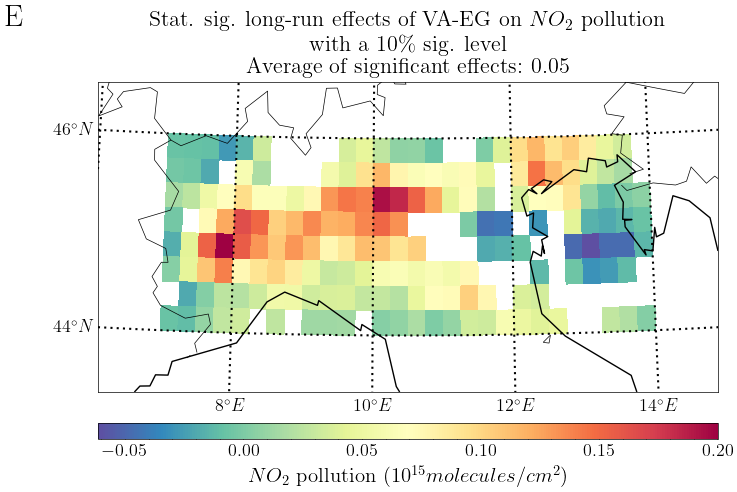

Saved plot to ./plots/no2_application/FCE-HWE_sigLTE_map_hall_bs.pdf


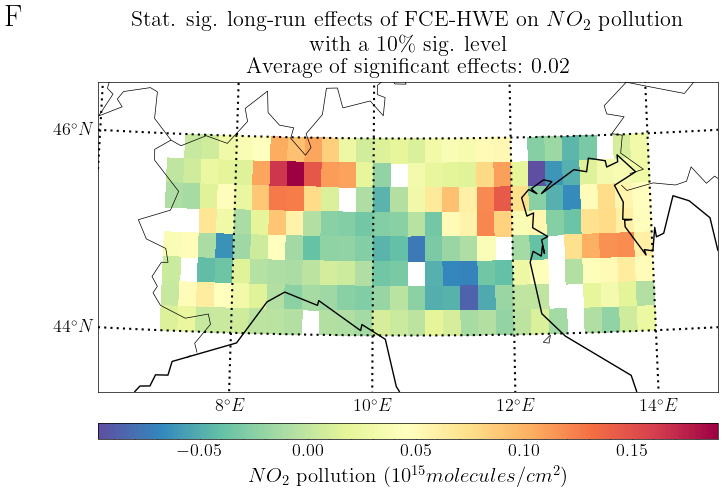

In [81]:
#Hall
plot_significant_LTE(Psi_inf[:224,224:],bs_low_hall,bs_up_hall,dataframe.var_names[components:],lats,lons,no2_units,"hall_bs")